In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
from sodapy import Socrata
import datetime

class FuturePrediction:
    """Time series cross-validator
    
            Provides train/test indices to split data in train/test sets.

    Parameters
    ----------
    train_length : int
        Length of training period.
    
    future_time : int
        Number of time periods in the future we want to predict
        
    interval : int, default=1
        One out of this many time periods is chosen to validate
    
    randomize : bool, default=False
        Randomize which days are chosen to validate
    """
    def __init__(self, train_length, future_interval,
                 interval=1, randomize=False, cumulative=False,
                start=0):
        self.train_length = train_length
        self.future_interval = future_interval
        self.interval = interval
        self.randomize = randomize
        self.cumulative = cumulative
        self.start = start
        
    def split(self, df):
        length = len(df)
        index = self.start
        max_index = length - self.train_length - self.future_interval
        while index < max_index:
            if self.cumulative:
                yield np.arange(index+self.train_length), \
                        np.array([index+self.train_length+self.future_interval-1])
            else:
                yield np.arange(index, index+self.train_length), \
                        np.array([index+self.train_length+self.future_interval-1])
            if self.randomize:
                index += np.randint(1, 2*self.interval)
            else:
                index += self.interval

def date_to_index(date_string):
    df = covid_state_data_normalized["LA"]
    for n in df.index:
        if df.date.loc[n] >= date_string:
            return n
    raise ValueError("Date out of range")
    
state_populations = pd.read_csv("../data/input/state_populations_2019.csv")

In [2]:
# Download data from CDC and preprocess

dataframe_list = [] # Downloaded dataframes go into this list

# COVID-19 cases
client = Socrata("data.cdc.gov",
                "YeLTGbOCV2gjoCenq2ve5LzDm")
for record_identifier in ["9mfq-cb36"]:#, "unsk-b7fc"]:
    results = client.get(record_identifier, limit=50000)
    df = pd.DataFrame.from_records(results)
    dataframe_list.append(df)

# COVID-19 hospitalizations
client = Socrata("healthdata.gov",
                "YeLTGbOCV2gjoCenq2ve5LzDm")
results = client.get("g62h-syeh", limit=50000)
df = pd.DataFrame.from_records(results)
dataframe_list.append(df)

# We only want a few columns from each dataset
pruned_df_list = []

df = dataframe_list[0]
df_pruned = df[["submission_date","state","new_case"]]
pruned_df_list.append(df_pruned.rename({"submission_date":"date",
                                       "new_case":"cases"}, axis=1))

df = dataframe_list[1]
df_pruned = df[["date","state","inpatient_beds_used_covid"]]
pruned_df_list.append(df_pruned.rename({"inpatient_beds_used_covid":"beds"},
                                       axis=1))

# Include only date, not time, in date column
for df in pruned_df_list:
    for n in df.date.index:
        df.date[n] = df.date[n].split("T")[0]

# Start data on 2020-04-01, end datasets at the earliest
# end date of the two datasets (they are sometimes off by one)
start_date = "2020-04-01"
end_date = min(df.date.max() for df in pruned_df_list)

# 50 states plus Washington DC and Puerto Rico
state_list = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
              'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
              'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE',
              'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR',
              'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI',
              'WV', 'WY']

# Separate data by state and save to .csv files
covid_state = {}
for state in state_list:
    for n in [1,0]:
        df = pruned_df_list[n]
        df_state = df.loc[df.state == state].copy()
        df_state.sort_values("date", inplace=True)
        df_state = df_state.loc[(df_state.date>=start_date) & \
                               (df_state.date<=end_date)].copy()
        if n == 1:
            df_all = df_state[["date"]].reset_index(drop=True).copy()
            df_all["beds"] = df_state["beds"].values.astype(np.float)
        elif n == 0:
            df_all["cases"] = df_state.cases.values.astype(np.float)

    L = []
    
    # Add 7-day average case numbers
    for n in range(len(df_all)):
        if n < 6:
            L.append(np.mean(df_all.cases.loc[:n]))
        else:
            L.append(np.mean(df_all.cases.loc[n-6:n]))
    df_all["cases_7day"] = L

    covid_state[state] = df_all[["date","beds","cases_7day"]].copy()

covid_state_data_normalized = {}

# Normalize by population
for state in state_list:
    population = state_populations[state][0]
    covid_state_data_normalized[state] = covid_state[state].copy()
    for column in ["beds", "cases_7day"]:
        normalized_data = covid_state[state][column]/population*10**5
        covid_state_data_normalized[state][column] = normalized_data.copy()

# Trim outliers
for state in state_list:
    df = covid_state_data_normalized[state]
    series = df.beds.copy()
    for n in range(1,len(df)-1):
        a,b = df.iloc[n-1].beds, df.iloc[n+1].beds
        MIN, MAX = min(a,b), max(a,b)
        if not (MIN*0.6 < df.iloc[n].beds < MAX*1.4):
            series.iloc[n] = (a+b)/2
    df.beds = series
    
# Add lag variables        
for state in state_list:
    for s in ["beds","cases_7day",]:
        for f in range(1,31):
            covid_state_data_normalized[state][f"{s}_{f}"] = \
                covid_state_data_normalized[state][s].shift(f)
    covid_state_data_normalized[state] = covid_state_data_normalized[state].copy()

In [3]:
%%time
# Compute range of ARIMA predictions for each state
# These predictions are used to train Ridge model

def get_arima_forecast(state):
    df = covid_state_data_normalized[state]
    Q = {}
    for n in range(1,15):
        Q[f"arima_{n}"] = pd.Series(index=df.index, dtype='float64')
#         np.zeros(validation_end_date - validation_start_date + 1)
    for begin in range(validation_start_date-14, validation_end_date):
        with warnings.catch_warnings():
            success = False
            n = 50
            while not success:
                try:
                    warnings.filterwarnings("ignore")
                    model = ARIMA(df.loc[n:begin].beds, order = (5,2,2))
                    model_fit = model.fit()
                    predicted = model_fit.forecast(14)
                    if predicted.max() > df.loc[begin].beds * 4: # Some sort of numerical error
                        raise ValueError()
                    success = True
                except ValueError:
                    # ARIMA.fit sometimes has difficulty with L/U
                    # decomposition. If this happens, adjust the training
                    # window and try again.
                    n += 1
        for n in range(14):
            N = n+1
            if True or validation_start_date <= begin+N <= validation_end_date:
                Q[f"arima_{N}"][begin+N] = predicted.iloc[n]
    return Q, state

validation_end_date = date_to_index(covid_state_data_normalized["OR"].date.iloc[-1])
validation_start_date = validation_end_date - 40

start, stop = validation_start_date, validation_end_date

print("Computing all ARIMA predictions for each state (this may take a while)")
print("Completed: ", end='')
with Pool(3) as pool: # Each process tops out at around 500% CPU usage
    for Q, state in pool.imap_unordered(get_arima_forecast, state_list):
        df = covid_state_data_normalized[state].copy()
        Q_df = pd.DataFrame(Q)
        df[Q_df.columns] = Q_df * (Q_df>0) # Make sure it's non-negative
        covid_state_data_normalized[state] = df.copy()
        print(f"{state}, ", end='')
print()

# Uncomment to back up computations

# for state in state_list:
#     covid_state_data_normalized[state].to_csv(f"bak/{state}.csv",
#                                              index=False)

Computing all ARIMA predictions for each state (this may take a while)
Completed: AL, AR, AZ, CA, AK, CO, CT, DE, FL, DC, GA, IA, ID, IL, IN, HI, KY, KS, LA, MD, MA, MN, ME, MI, MO, MS, NC, MT, ND, NE, NM, NJ, NH, NV, OK, OH, NY, PA, OR, SC, SD, TN, PR, TX, RI, VA, UT, WA, WI, VT, WV, WY, 
CPU times: user 498 ms, sys: 45.8 ms, total: 544 ms
Wall time: 4min 22s


In [7]:
# Fit our models and make predictions

validation_end_date = date_to_index(covid_state_data_normalized["OR"].date.iloc[-1])
validation_start_date = validation_end_date - 25

start, stop = validation_start_date, validation_end_date
pred = {state:[] for state in state_list}
for state in state_list:
    df = covid_state_data_normalized[state]
    with warnings.catch_warnings():
        success = False
        n = 50
        while not success:
            try:
                warnings.filterwarnings("ignore")
                model = ARIMA(df.loc[n:].beds, order = (5,2,2))
                model_fit = model.fit()
                predicted = model_fit.forecast(14)
                if predicted.max() > df.iloc[-1].beds * 4: # Some sort of numerical error
                    raise ValueError()
                success = True
            except ValueError:
                # ARIMA.fit sometimes has difficulty with L/U
                # decomposition. If this happens, adjust the training
                # window and try again.
                n += 1
    df = df.loc[start:]
    for future in range(1,15):
        reg = Pipeline([('scaler', StandardScaler()),
                        ('ridge', Ridge(alpha=10))])
        reg.fit(df[[f"beds_{future}",
                    f"cases_7day_{future}",
                   f"arima_{future}"]].values,
               df.beds)
        arima_prediction = predicted.iloc[future-1]
        linear_prediction = reg.predict(np.concatenate((df.iloc[-1][["beds","cases_7day"]],
                              [arima_prediction])).reshape(1,-1))[0]
        baseline_prediction = df.beds.iloc[-1]
        prediction = np.mean([arima_prediction,
                             linear_prediction,
                             baseline_prediction])
        pred[state].append(prediction)
        
for state in state_list:
    pred[state] = np.array(pred[state]) * state_populations[state][0] / 10**5

In [11]:
# Function for generating graphs with predictions

def show_prediction(state):
    actual = covid_state_data_normalized[state].beds.iloc[-22:] \
                        * state_populations[state][0] / 10**5
    predicted = np.concatenate(([actual.iloc[-1]],pred[state]))
    plt.figure(figsize=(12,9))
    plt.plot(range(len(actual)),actual,
             label="Observed",
            c="blue")
    plt.plot(range(len(actual)-1,len(actual)+len(predicted)-1),
             predicted,
             '--',
             label="Predicted",
            c="red")
    plt.plot([len(actual)-1], [actual.iloc[-1]],'o',
             c="black",markersize=8)
    plt.text(len(actual)+.4,actual.iloc[-1]*0.99,
             str(int(actual.iloc[-1])),
            fontsize=16,
            color="black")
    plt.legend()
    plt.xlabel("Date", fontsize=16)
    plt.ylabel("Beds in use", fontsize=16)

    # Add a few dates as labels to x-axis
    x_pos = []
    x_date = []
    end_date = covid_state_data_normalized[state].date.iloc[-1]
    for k in range(-3,3):  
        new_date = datetime.datetime.strftime(datetime.datetime.strptime(end_date,
                                                                         "%Y-%m-%d")\
                                              + datetime.timedelta(days=7*k),
                                                          "%Y-%m-%d")
        new_pos = len(actual)-1+7*k
        if k == 0:
            new_date += "\n(most recent\nobservation)"
        x_pos.append(new_pos)
        x_date.append(new_date)
    plt.xticks(x_pos, x_date, fontsize=12)
    title_string = f"COVID hospitalizations in {state}"
    plt.title(title_string, fontsize=22)

    plt.show()
    plt.close()

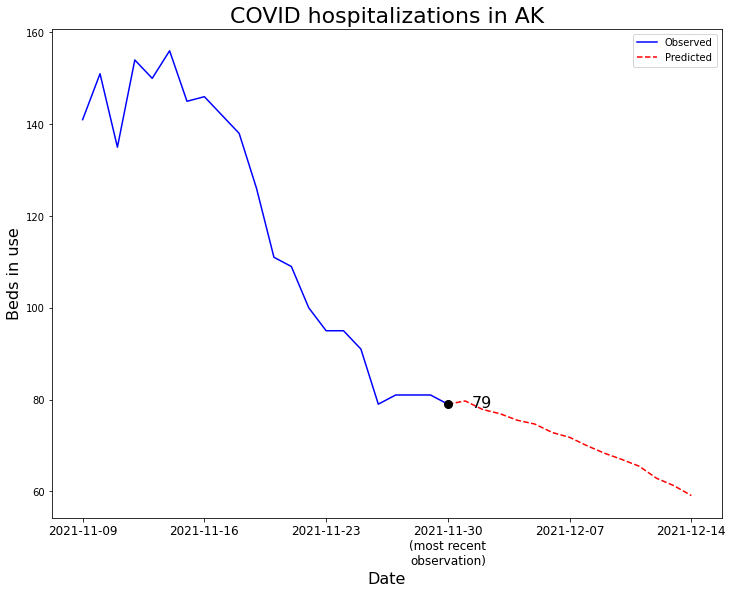

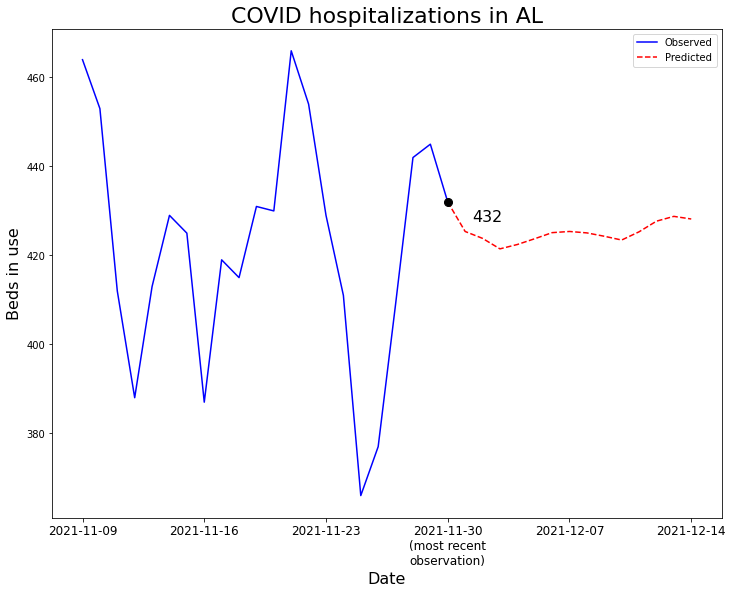

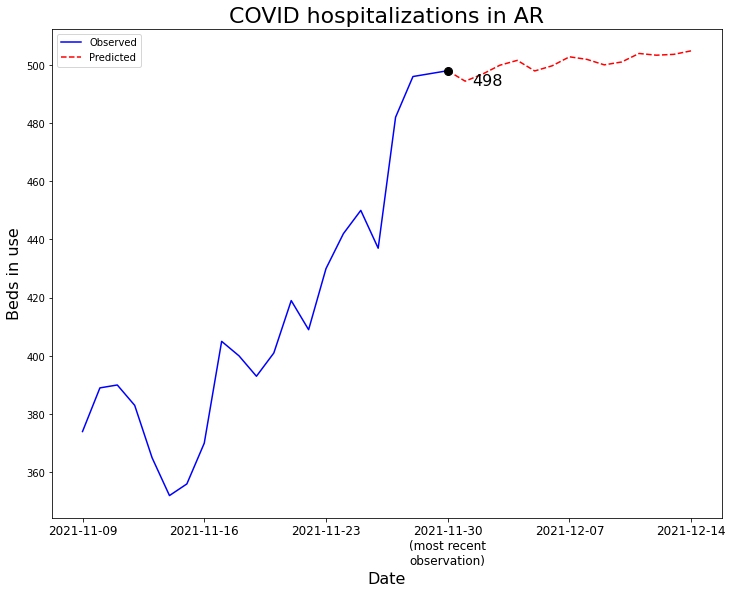

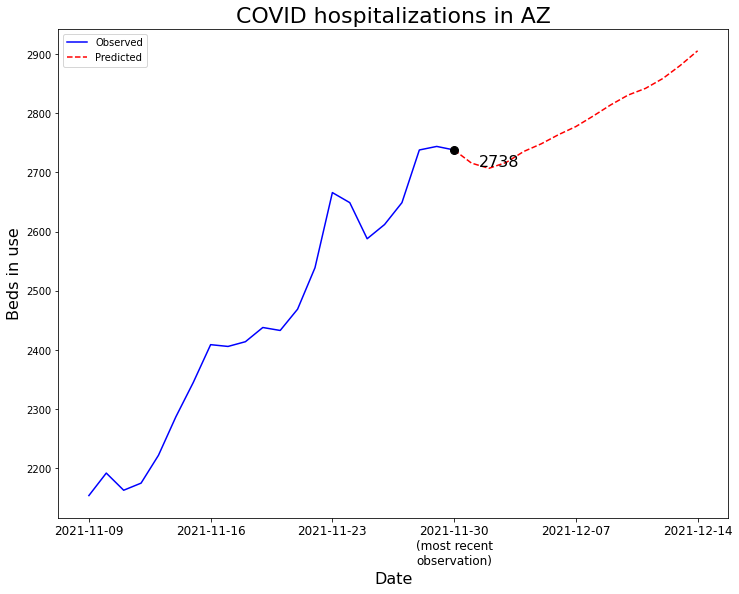

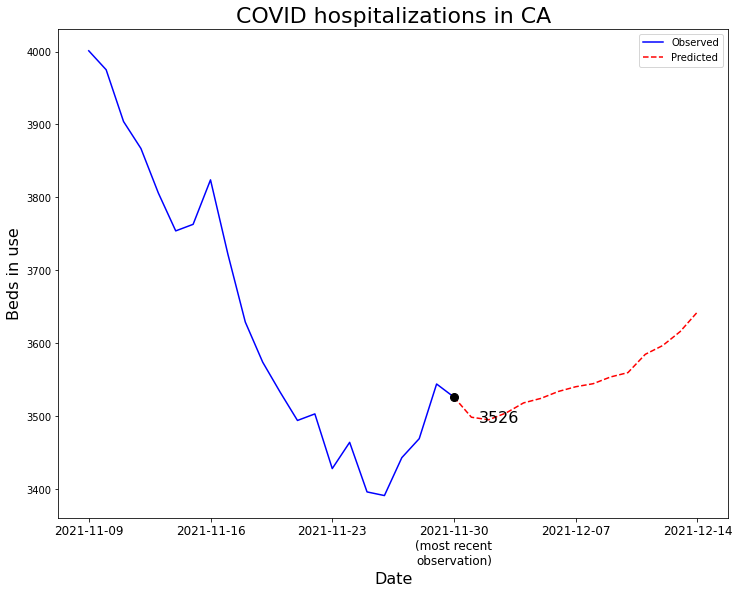

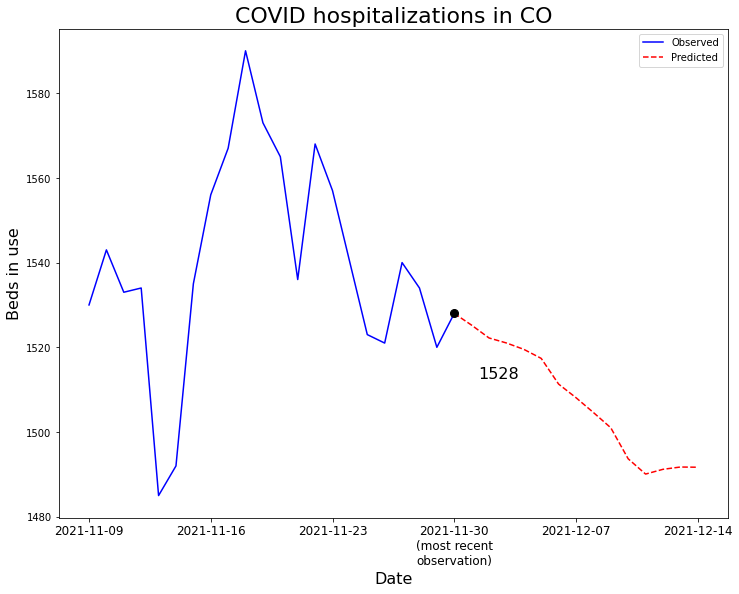

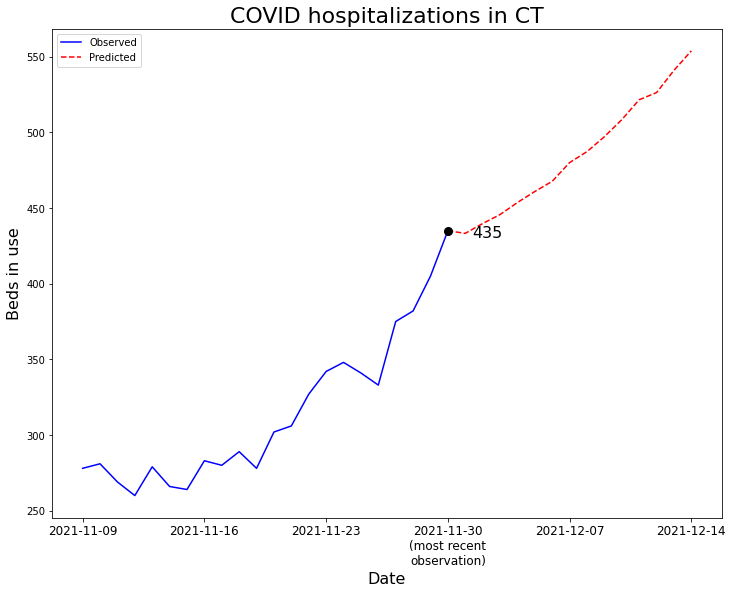

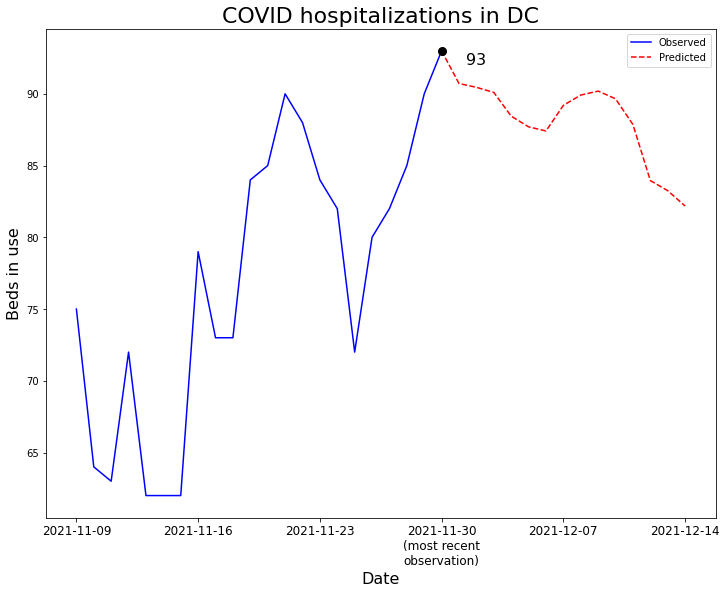

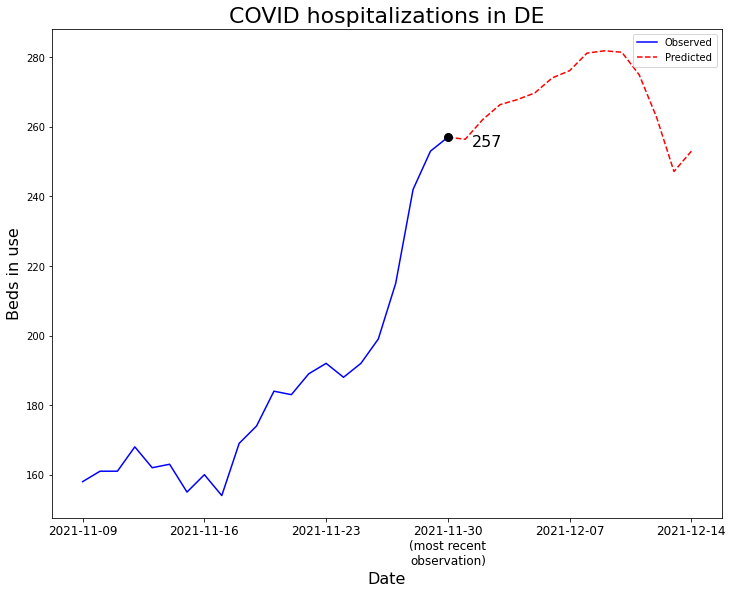

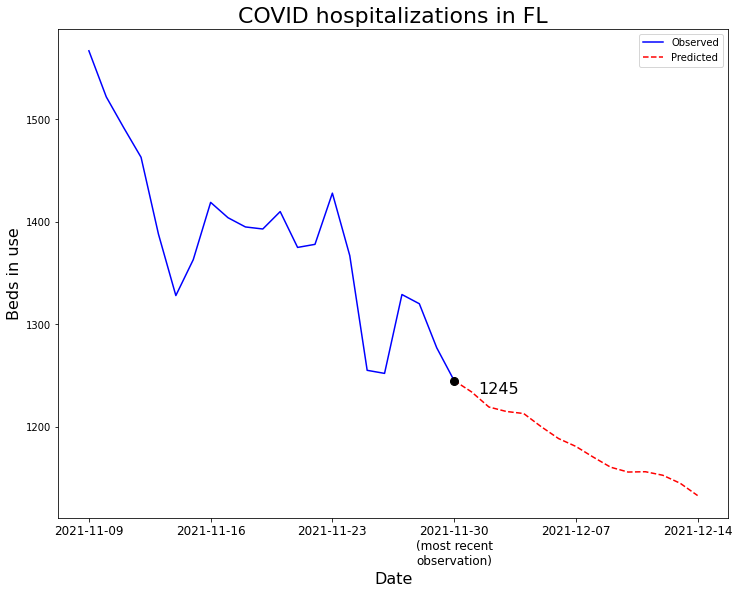

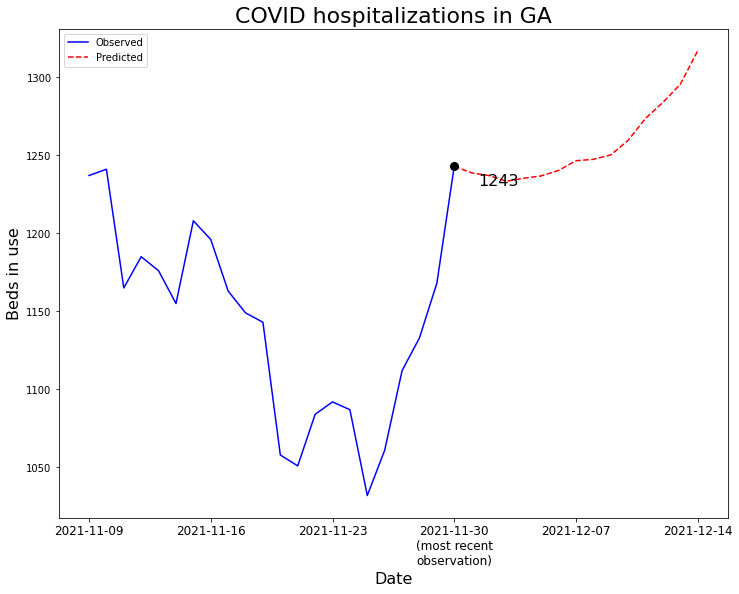

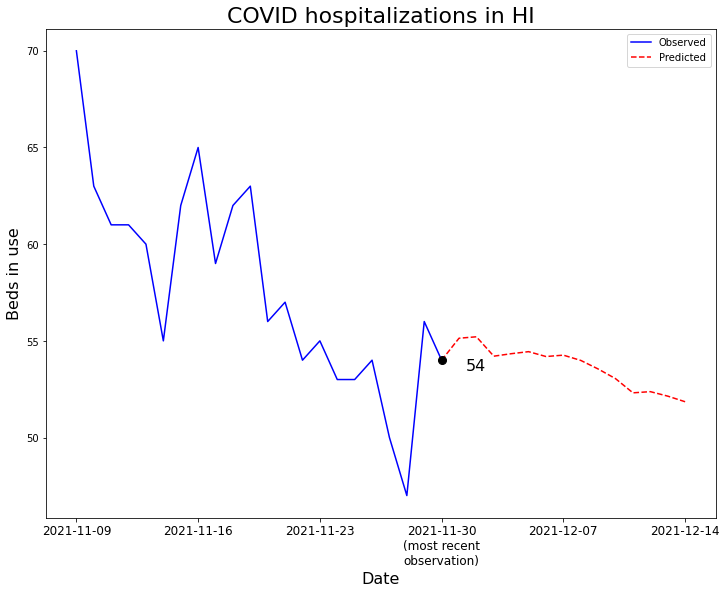

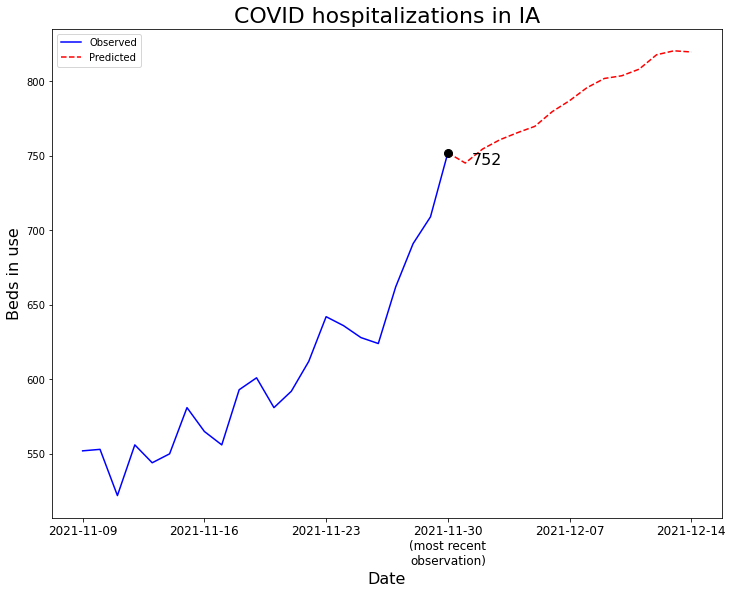

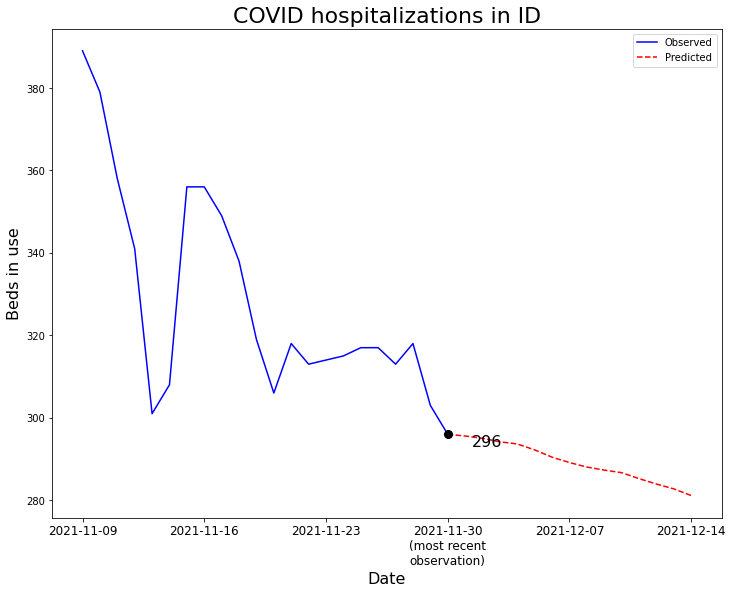

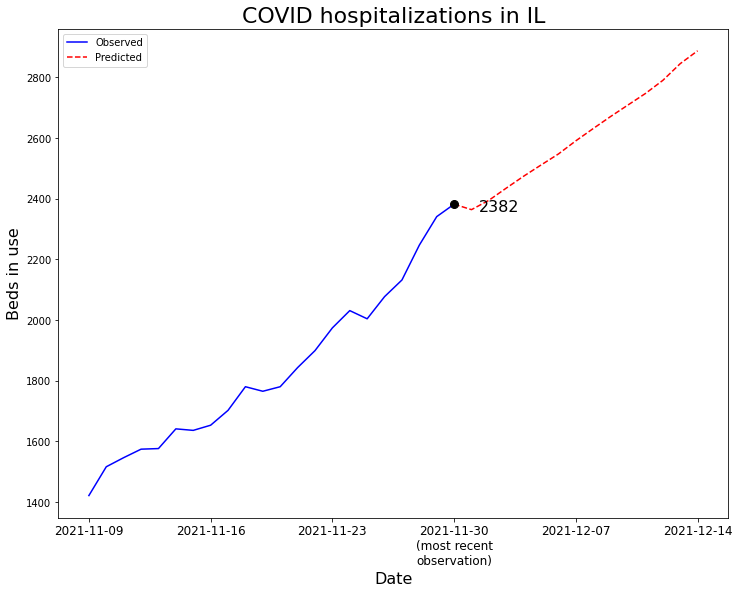

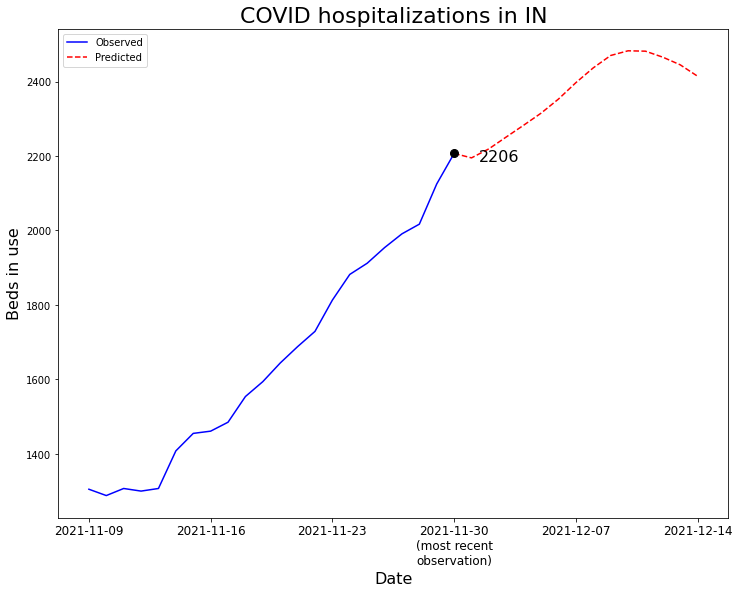

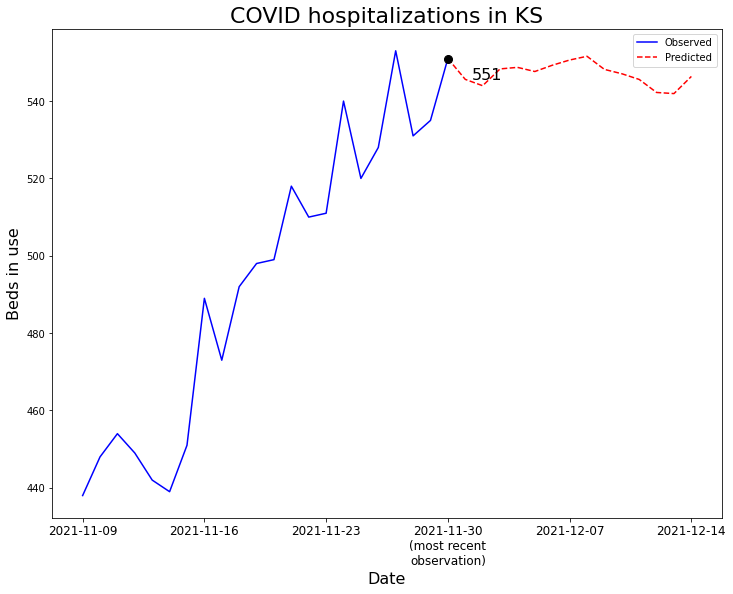

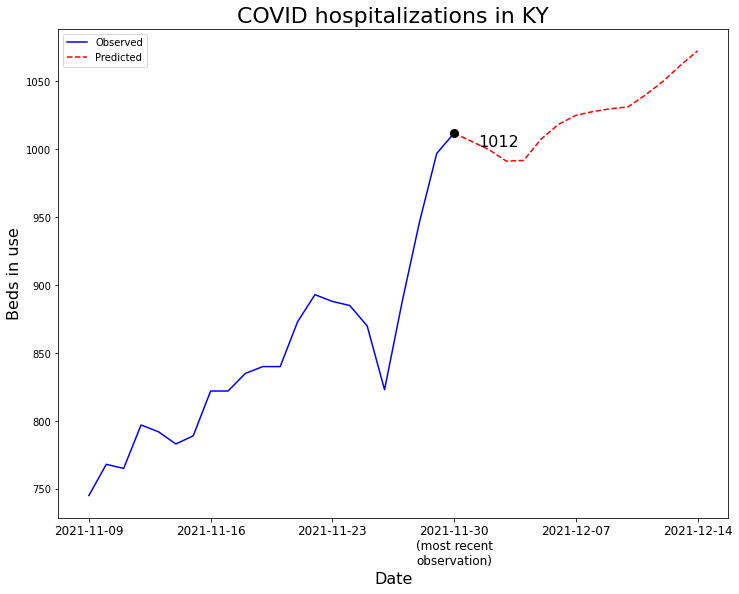

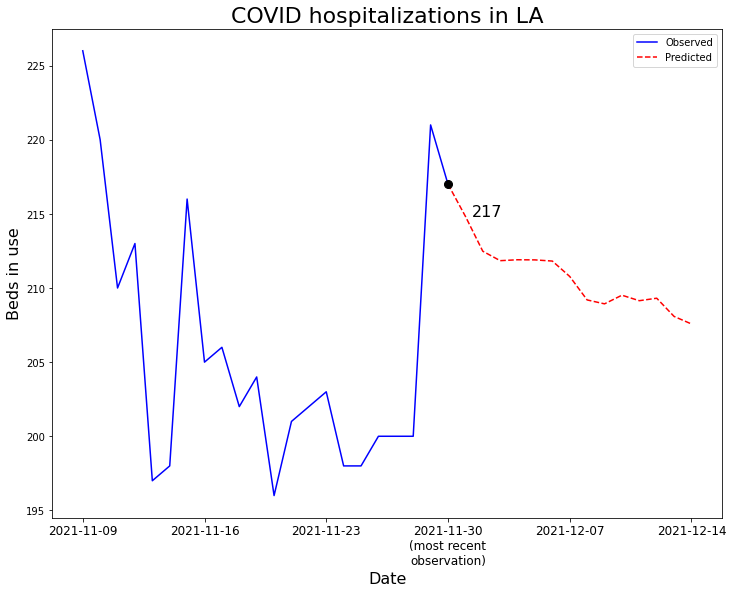

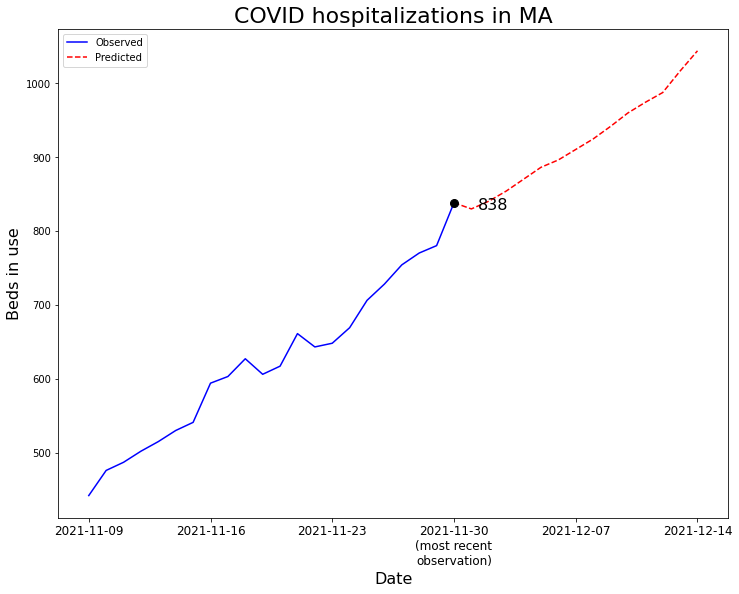

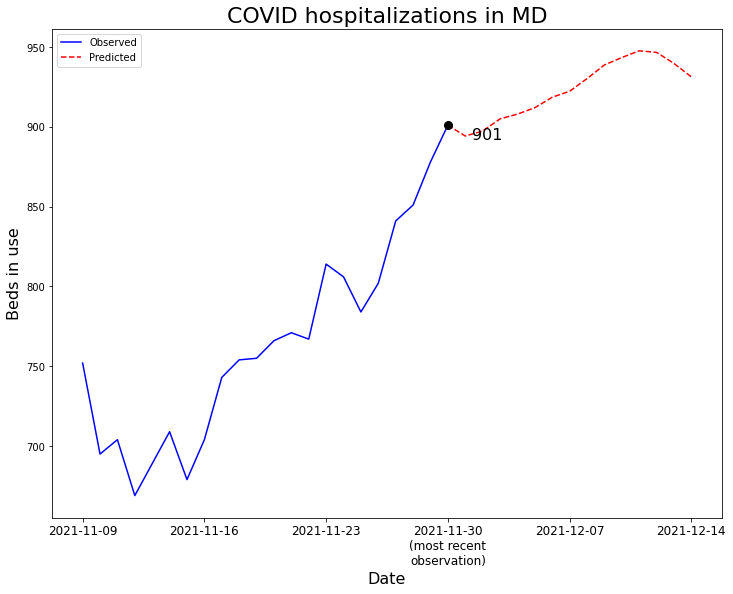

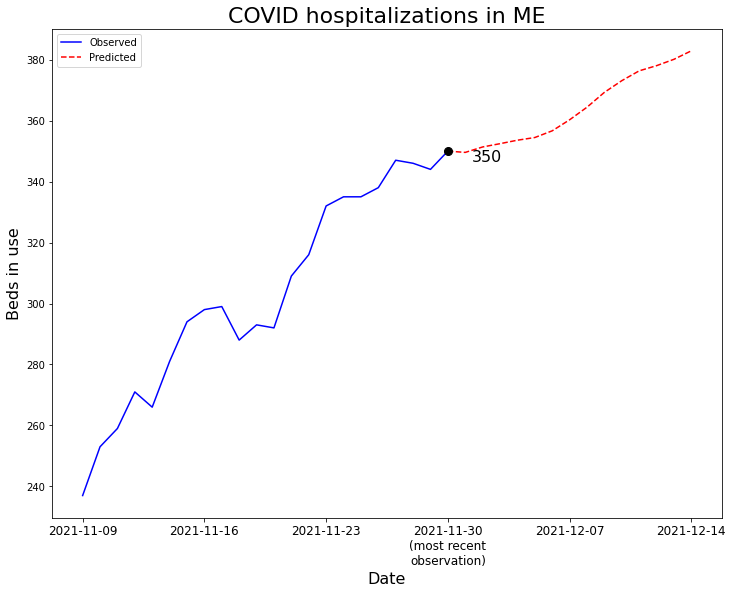

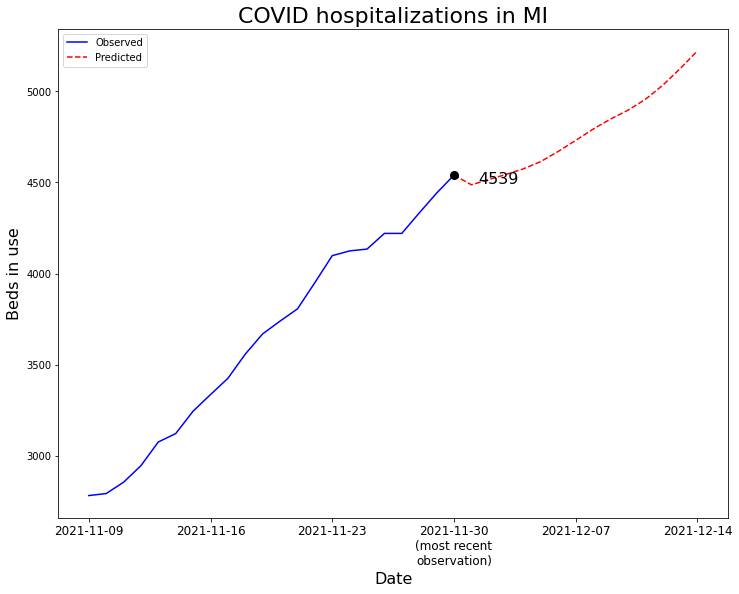

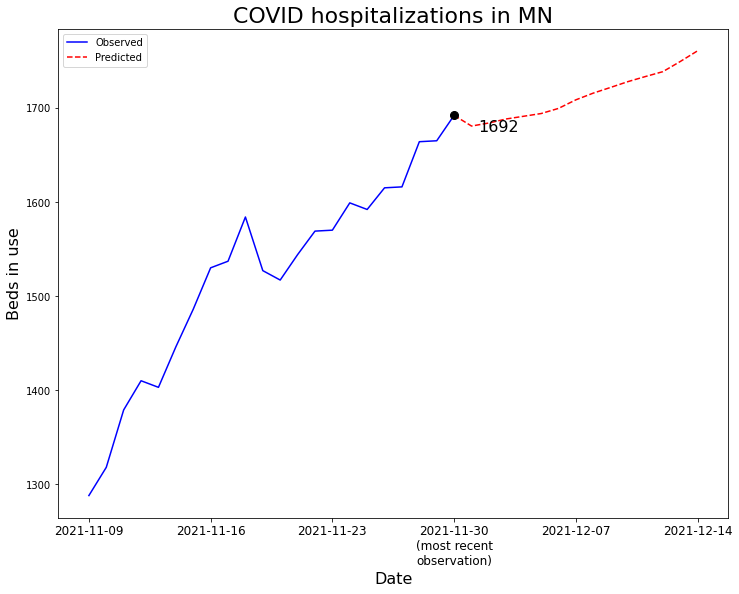

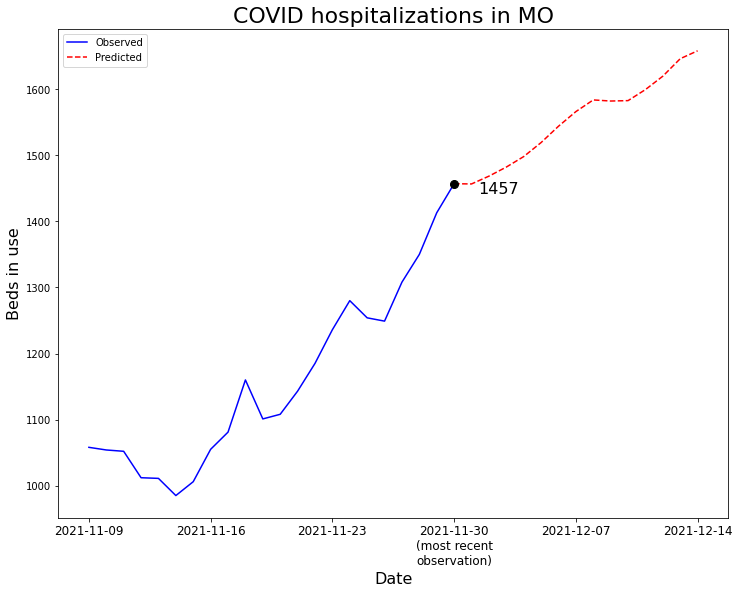

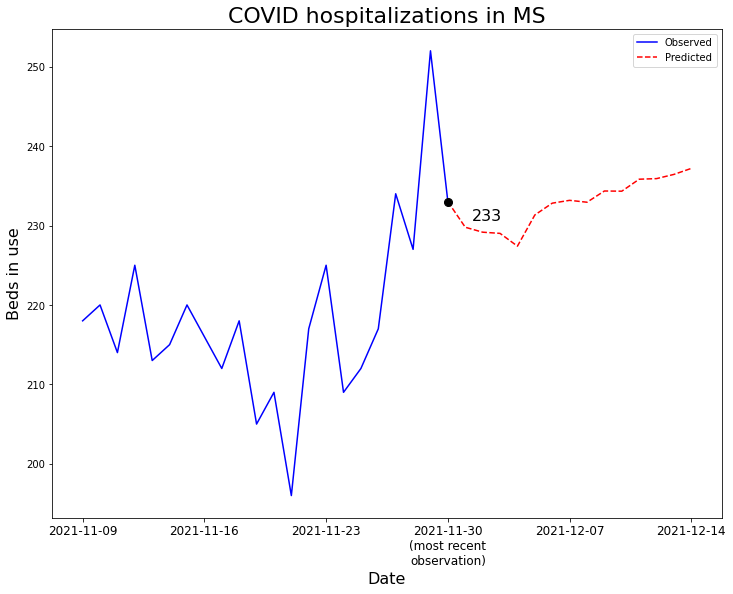

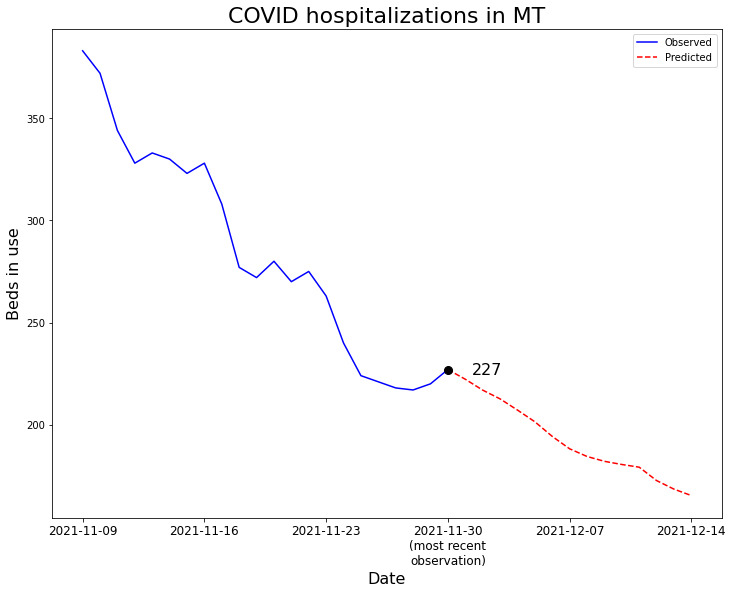

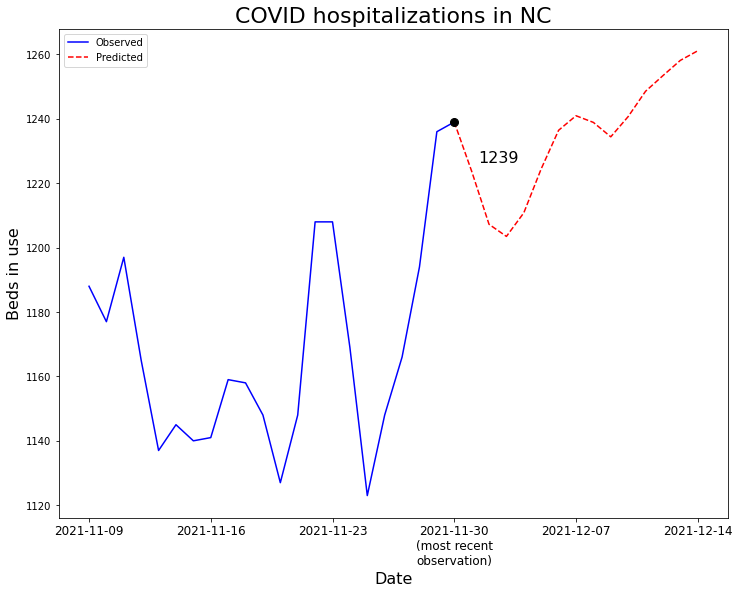

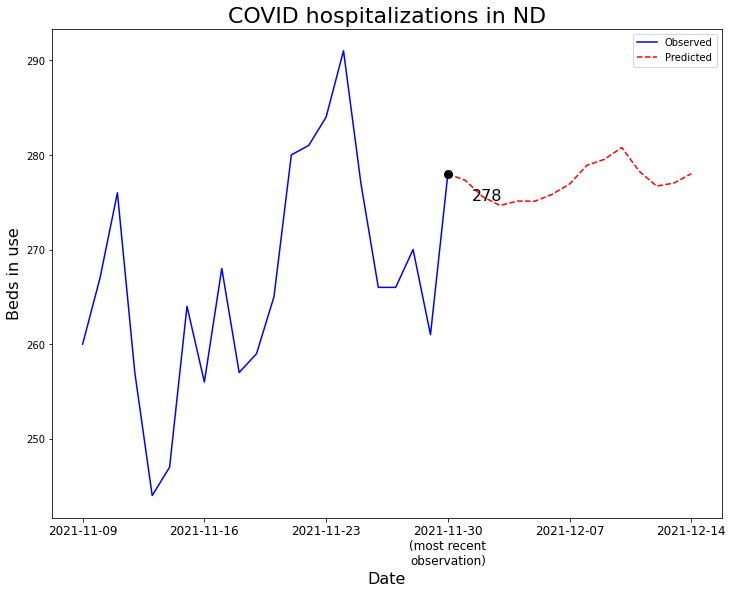

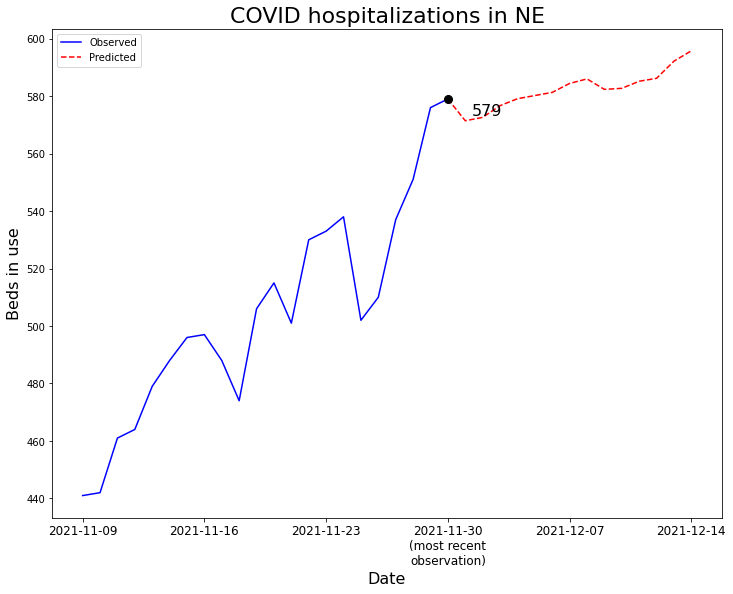

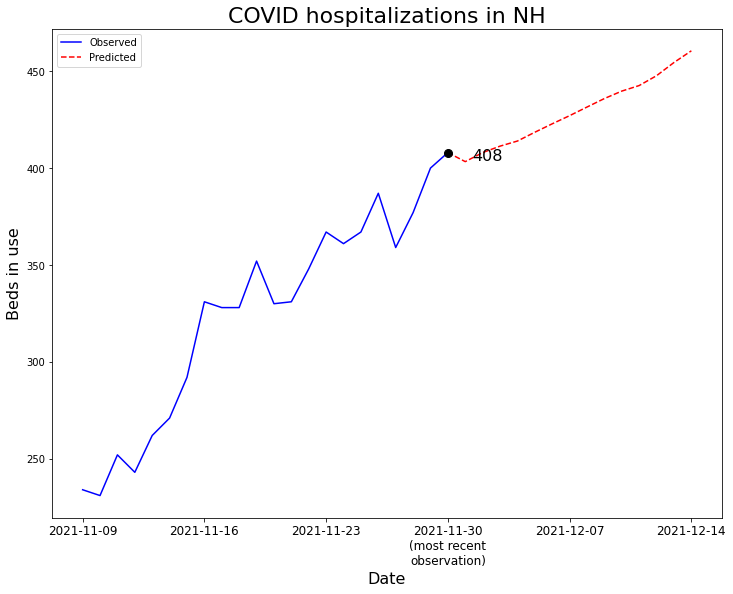

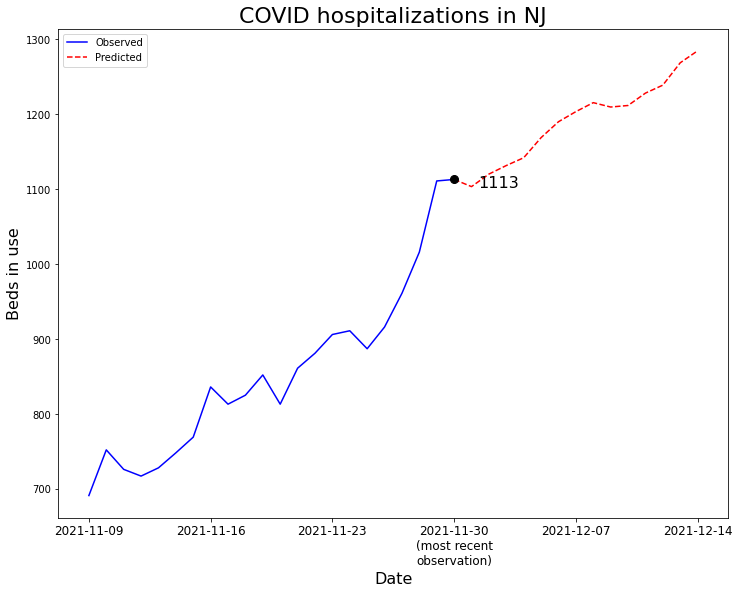

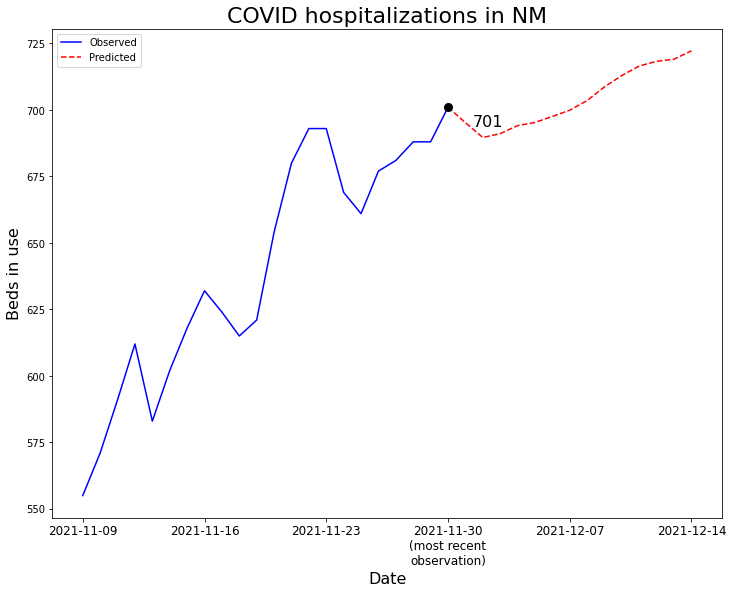

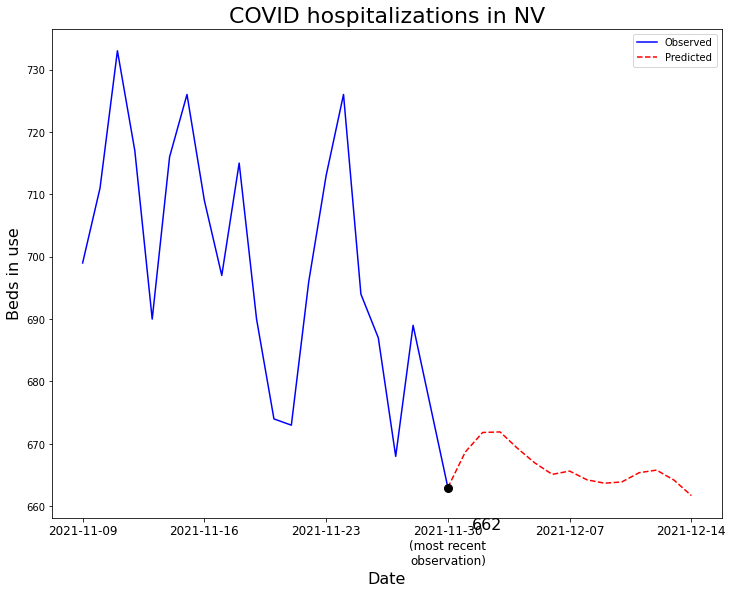

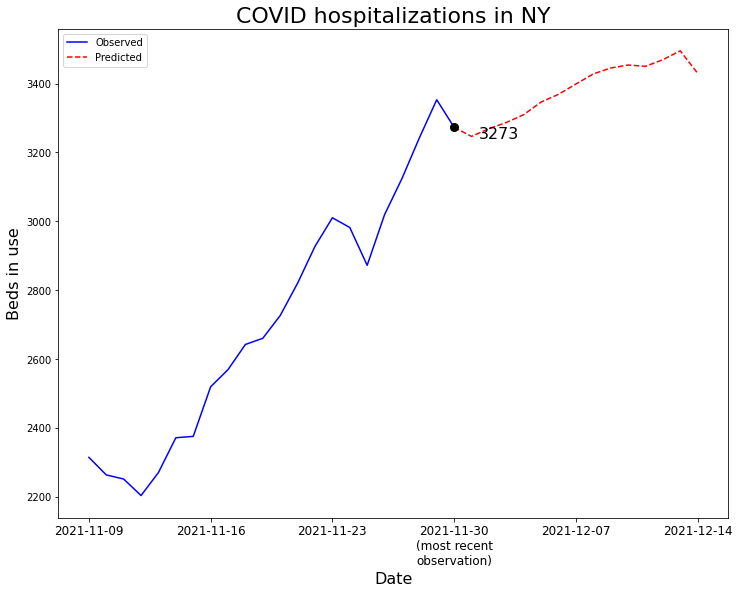

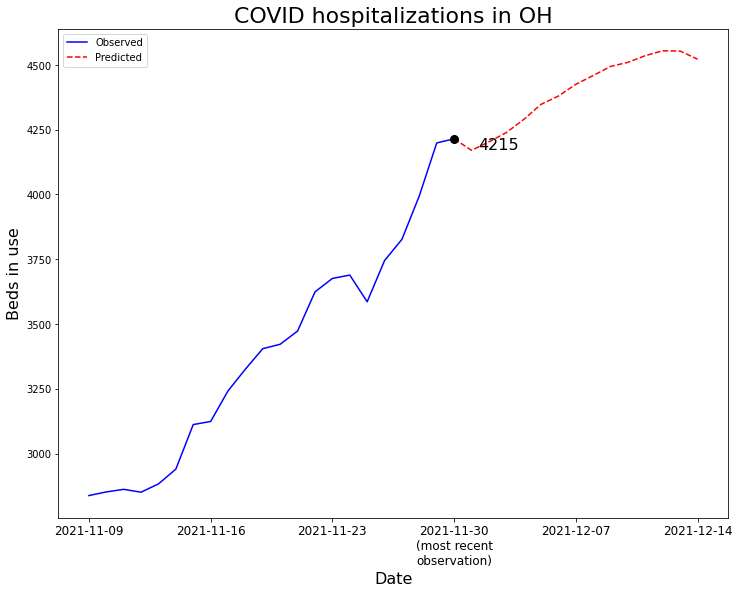

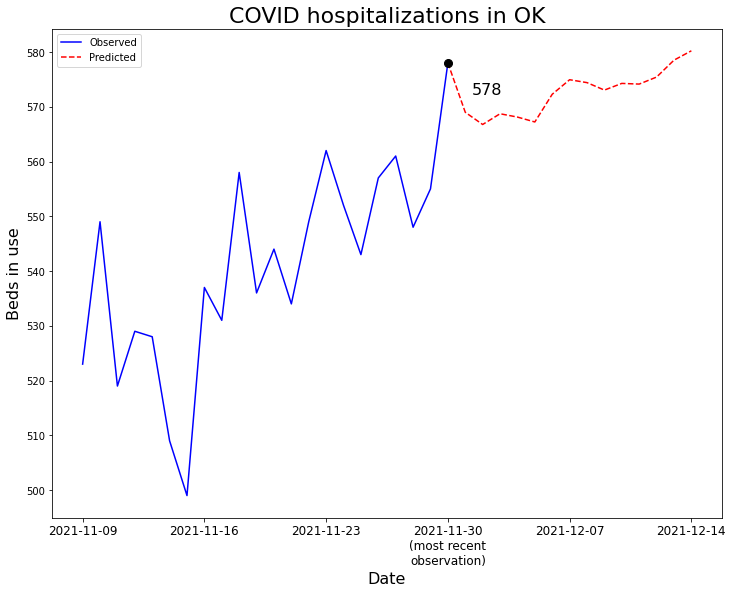

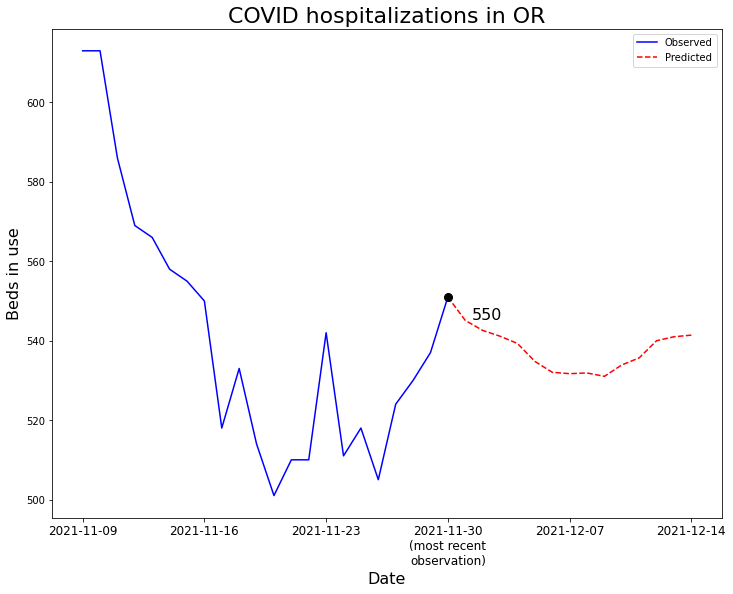

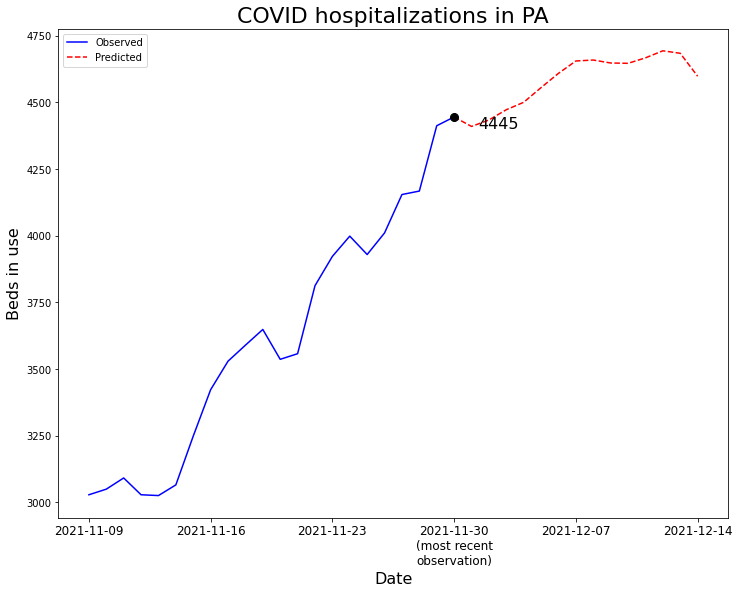

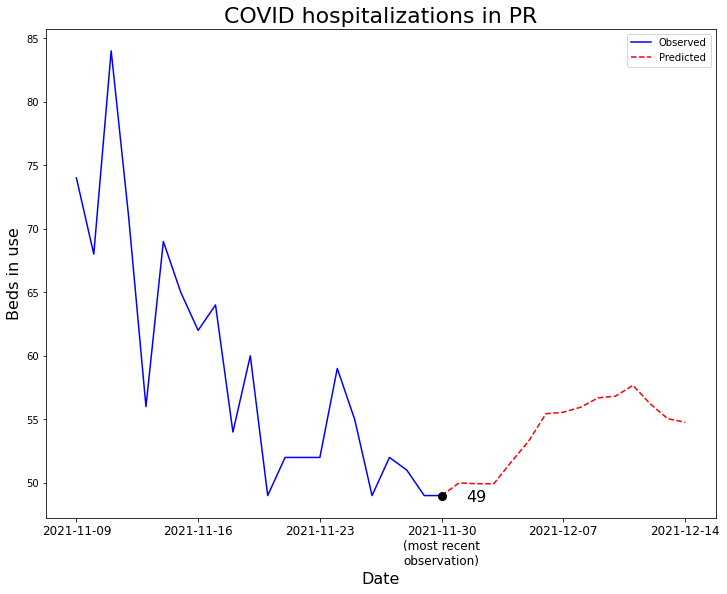

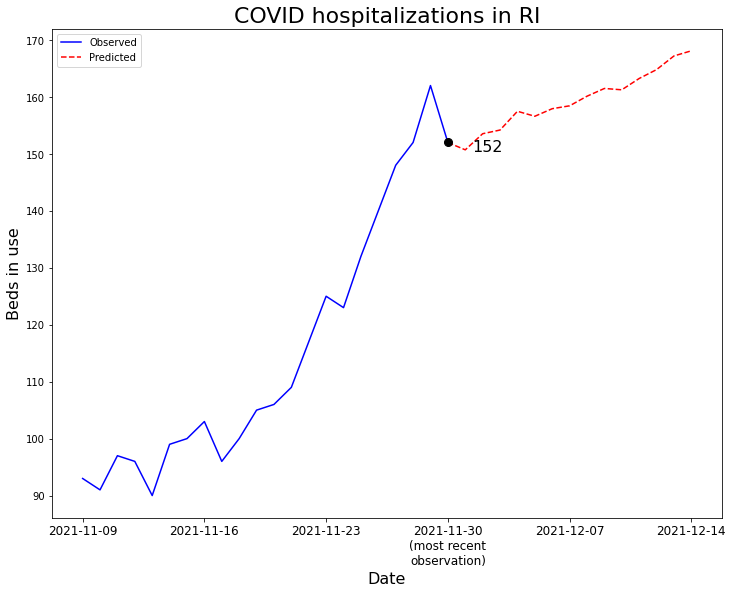

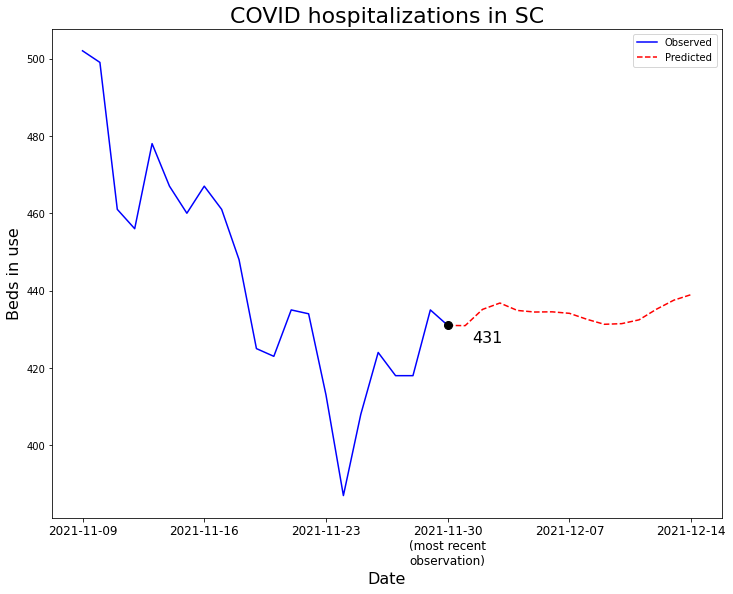

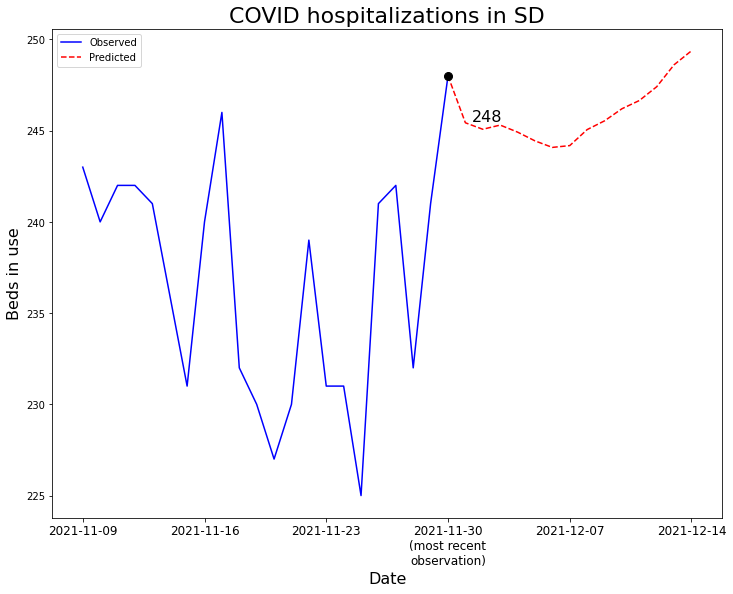

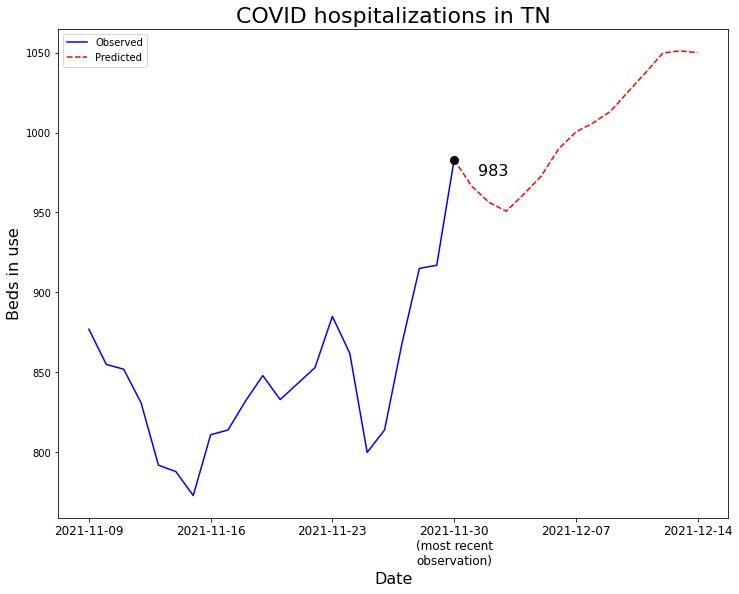

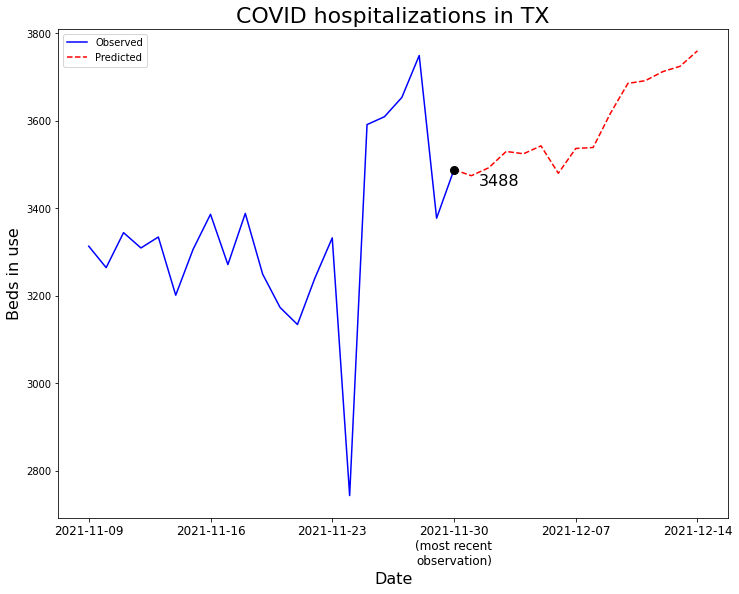

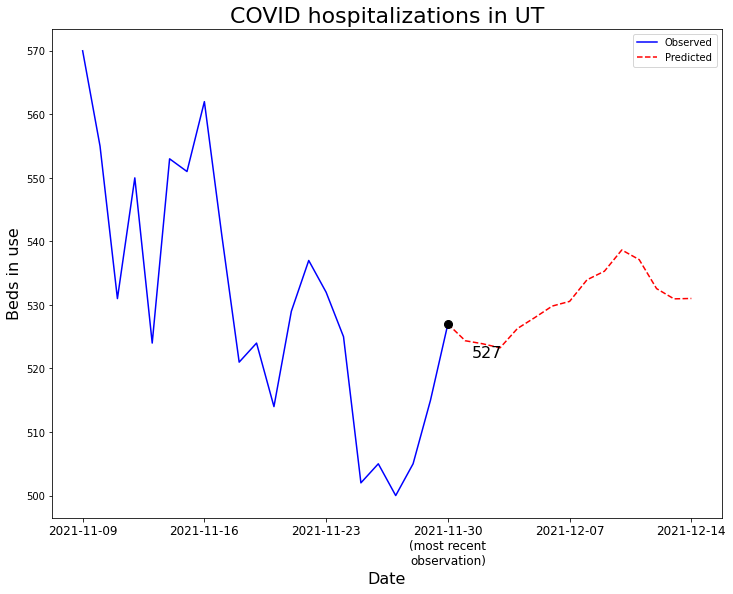

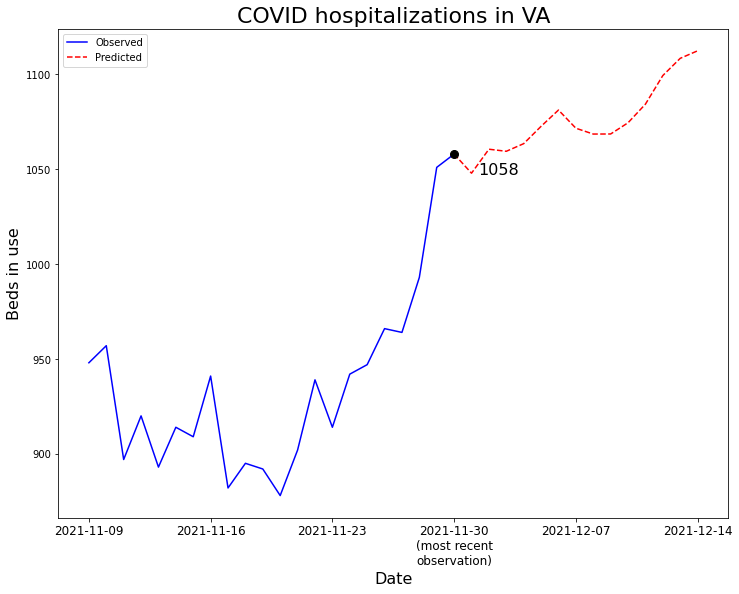

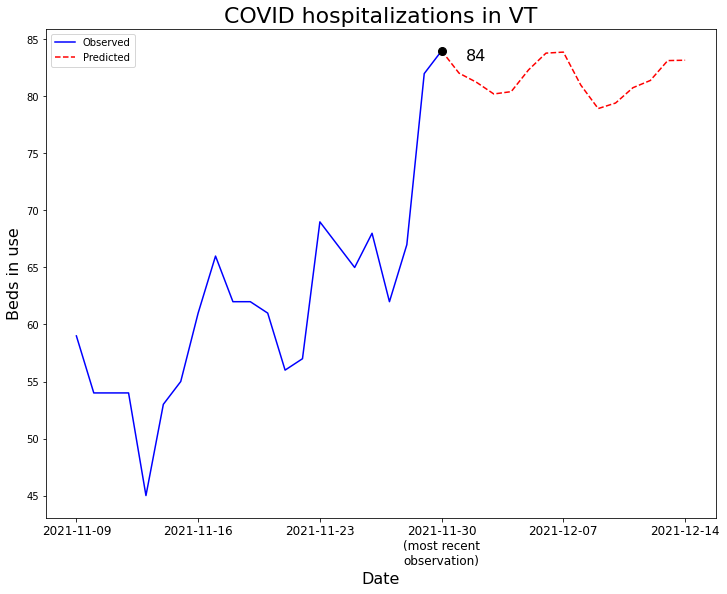

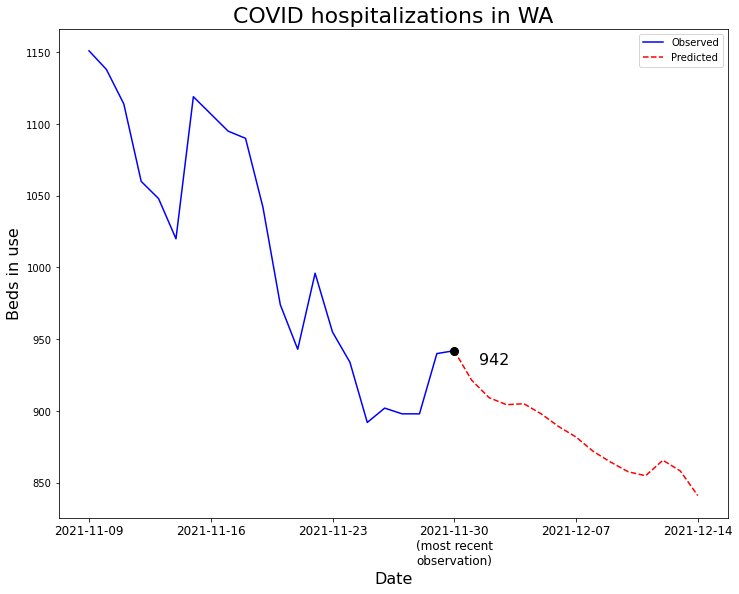

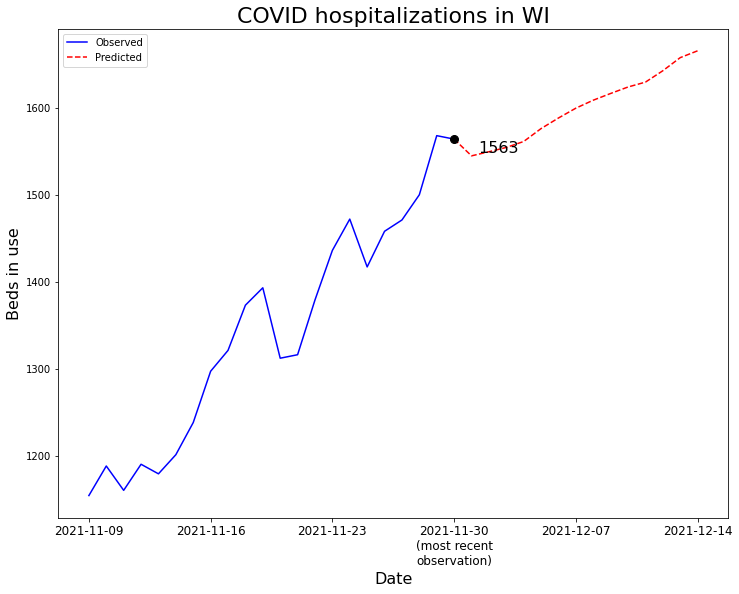

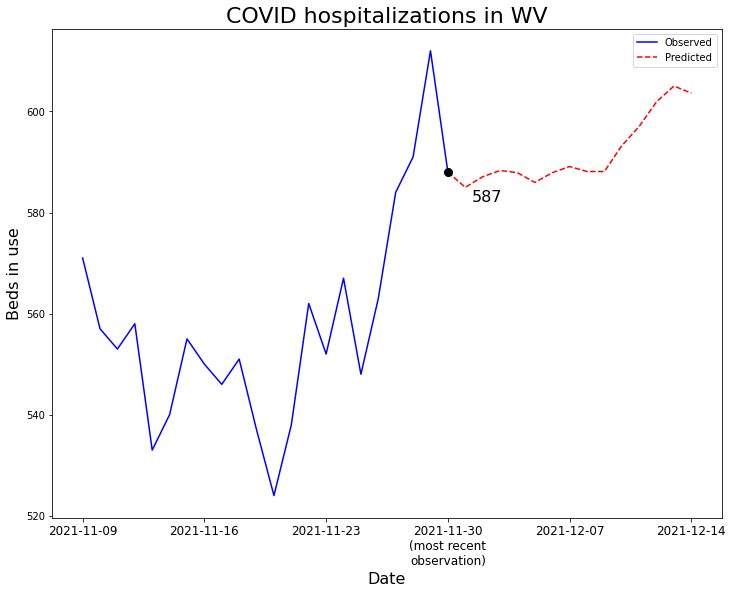

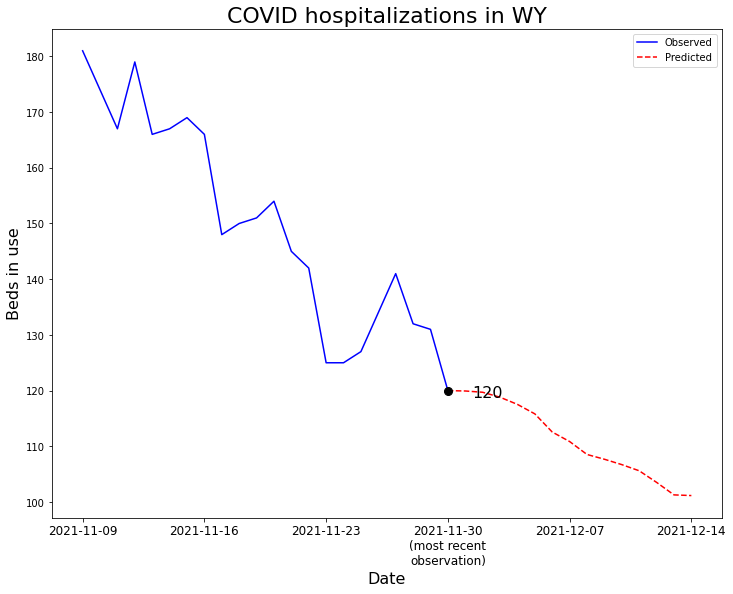

In [12]:
# Check out our predictions
for state in state_list:
    show_prediction(state)